In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.learn_utils import fit_dnn
from bgspy.learn import LearnedFunction


In [3]:
FIT_DIR = '../data/slim_sims/bmap_hg38/fits/'

res = load_learnedfuncs_in_dir(FIT_DIR)
res.keys()

2022-05-20 18:35:48.441093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 18:35:51.104782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 485 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-05-20 18:35:51.107081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6120 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-05-20 18:35:51.108951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:

dict_keys([(0, 0, 0, 0, 4), (0, 0, 4, 2, 0), (0, 0, 0, 0, 2)])

In [4]:
y, X = res[(0, 0, 0, 0, 2)][0].func.y, res[(0, 0, 0, 0, 2)][0].func.X

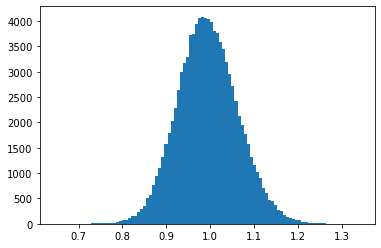

In [5]:
_ = plt.hist(y, 100)

In [6]:
class DownsampleTarget:
    def __init__(self, y, bins=100, rng=None):
        self.y = y.squeeze()
        self.bins = bins
        self.hist, self.bin_edges = np.histogram(y, bins=bins)
        self.seed = rng if isinstance(rng, int) else None
        self.rng = np.random.default_rng(self.seed) if rng is None else rng

    def downsample(self, level, truncate=True, replace=False):
        bin_item_idx = np.digitize(self.y, self.bin_edges)
        bin_items = defaultdict(list)
        
        for i, idx in enumerate(bin_item_idx.tolist()):
            bin_items[idx].append(i)
        sample = []
        for vals in bin_items.values():
            if len(vals) <= level:
                if not truncate:
                    sample.extend(vals)
            else:
                sample.extend(self.rng.choice(vals, size=level, replace=replace).tolist())
        return np.array(sample)

    def plot(self):
        return plt.bar(self.bin_edges[:-1], self.hist, width=np.diff(self.bin_edges)[0])
    

In [7]:
m = DownsampleTarget(y)
#plt.hist(m.downsample(level=100), bins=m.bin_edges)
idx = m.downsample(level=100)

In [8]:
domain = {'mu': (-10, -7, True),
         'sh': (-5, -1, True),
         'L': (1, 10000, False),
         'rbp': (-12, -7, True),
         'rf': (-10, -0.824, True)}

In [9]:
n = X.shape[0]
random_downsample = np.random.choice(np.arange(n), len(idx), replace=False)
func_rand = LearnedFunction(X[random_downsample, :], y[random_downsample, :], domain=domain)
func_rand.split()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, None)
  - sh ∈ [-5, -1] (log10, None)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, None)
  - rf ∈ [-10, -0.824] (log10, None)
 fixed fixed(s) (based on metadata):
Features normalized? False
Features split? True, test size: 20.0% (n=1,100)
Total size: 5,500

(array([   5.,   44.,  202.,  685., 1412., 1463., 1043.,  457.,  151.,
          38.]),
 array([0.73800758, 0.78597689, 0.83394619, 0.8819155 , 0.92988481,
        0.97785411, 1.02582342, 1.07379273, 1.12176204, 1.16973134,
        1.21770065]),
 <BarContainer object of 10 artists>)

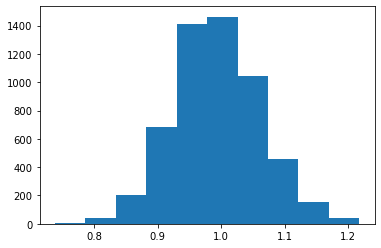

In [10]:
plt.hist(func_rand.y)

In [11]:
func = LearnedFunction(X[idx, :], y[idx, ], domain=domain)
func.split()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, None)
  - sh ∈ [-5, -1] (log10, None)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, None)
  - rf ∈ [-10, -0.824] (log10, None)
 fixed fixed(s) (based on metadata):
Features normalized? False
Features split? True, test size: 20.0% (n=1,100)
Total size: 5,500

(array([551., 551., 553., 545., 555., 545., 556., 544., 552., 548.]),
 array([0.81270509, 0.85082444, 0.88894379, 0.92706314, 0.9651825 ,
        1.00330185, 1.0414212 , 1.07954055, 1.11765991, 1.15577926,
        1.19389861]),
 <BarContainer object of 10 artists>)

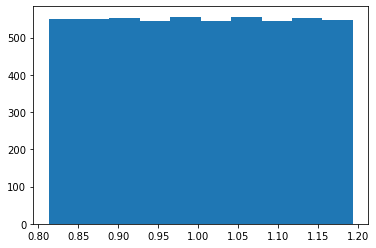

In [12]:
plt.hist(func.y)

In [13]:
%%time
model, hist = fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2)

Restoring model weights from the end of the best epoch: 1.
Epoch 00101: early stopping
CPU times: user 26.3 s, sys: 5.63 s, total: 32 s
Wall time: 16.7 s


In [14]:
%%time
model_rand, hist_rand = fit_dnn(func_rand, n128=0, n64=0, n32=0, n8=0, nx=2)

Restoring model weights from the end of the best epoch: 163.
Epoch 00263: early stopping
CPU times: user 1min 8s, sys: 14.4 s, total: 1min 22s
Wall time: 43.5 s


Text(0, 0.5, 'loss')

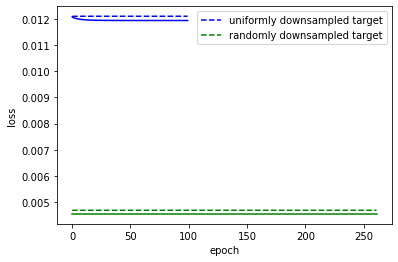

In [21]:
history = hist.history
history_rand = hist_rand.history

plt.plot(history['loss'][1:], c='b')
plt.plot(history['val_loss'][1:], linestyle='dashed', c='b', label='uniformly downsampled target')

plt.plot(history_rand['loss'][1:], c='g')
plt.plot(history_rand['val_loss'][1:], linestyle='dashed', c='g', label='randomly downsampled target')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')